# Classic VRPs

This notebook shows how to use PyVRP to solve two classic variants of the VRP: the capacitated vehicle routing problem (CVRP), and the vehicle routing problem with time windows (VRPTW).
It builds on the tutorial by solving much larger instances, and going into more detail about the various plotting tools and diagnostics available in PyVRP.

A CVRP instance is defined on a complete graph $G=(V,A)$, where $V$ is the vertex set and $A$ is the arc set. 
The vertex set $V$ is partitioned into $V=\{0\} \cup V_c$, where $0$ represents the depot and $V_c=\{1, \dots, n\}$ denotes the set of $n$ customers.
Each arc $(i, j) \in A$ has a weight $d_{ij} \ge 0$ that represents the travel distance from $i \in V$ to $j \in V$.
Each customer $i \in V_c$ has a demand $q_{i} \ge 0$.
The objective is to find a feasible solution that minimises the total distance.

A VRPTW instance additionally incorporates time aspects into the problem.
For the sake of exposition we assume the travel duration $t_{ij} \ge 0$ is equal to the travel distance $d_{ij}$ in this notebook.
Each customer $i \in V_c$ has a service time $s_{i} \ge 0$ and a (hard) time window $\left[e_i, l_i\right]$ that denotes the earliest and latest time that service can start.
A vehicle is allowed to arrive at a customer location before the beginning of the time window, but it must wait for the window to open to start the delivery. 
Each vehicle must return to the depot before the end of the depot time window $H$.
The objective is to find a feasible solution that minimises the total distance.

Let's first import what we will use in this notebook.

In [1]:
import matplotlib.pyplot as plt
from tabulate import tabulate
from vrplib import read_solution

from pyvrp import Model, read
from pyvrp.plotting import (
    plot_coordinates,
    plot_instance,
    plot_result,
    plot_route_schedule,
)
from pyvrp.stop import MaxIterations, MaxRuntime

## The capacitated VRP

### Reading the instance

We will solve the `X-n439-k37` instance, which is part of the [X instance set](http://vrp.atd-lab.inf.puc-rio.br/index.php/en/new-instances) that is widely used to benchmark CVRP algorithms.
The function `pyvrp.read` reads the instance file and converts it to a `ProblemData` instance. 
We pass the argument `round_func="round"` to compute the Euclidean distances rounded to the nearest integral, which is the convention for the X benchmark set.
We also load the best known solution to evaluate our solver later on.

In [2]:
INSTANCE = read("data/X-n439-k37.vrp", round_func="round")
BKS = read_solution("data/X-n439-k37.sol")

Let's plot the instance and see what we have.

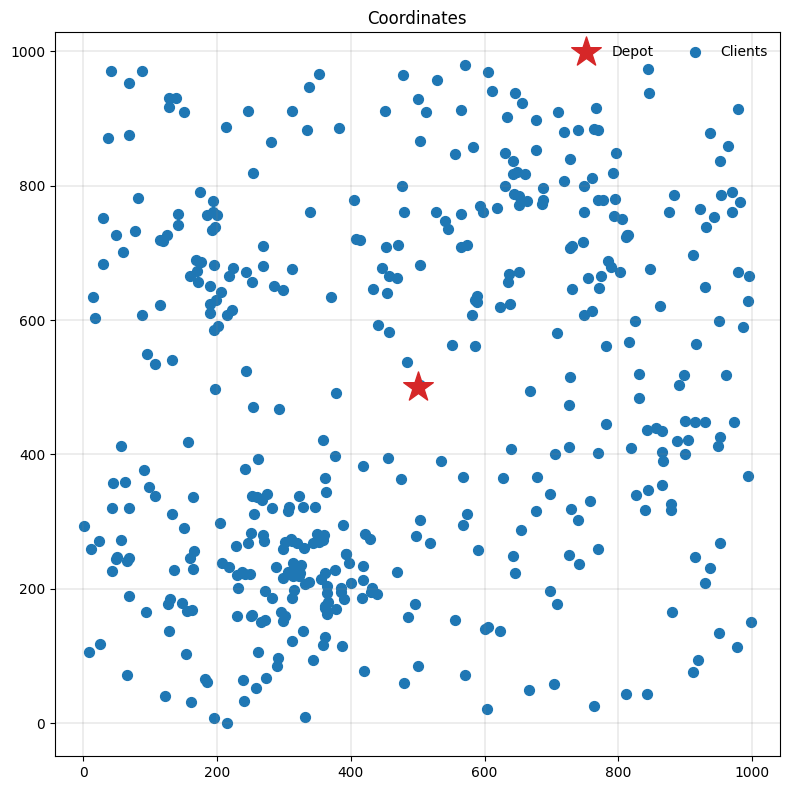

In [3]:
_, ax = plt.subplots(figsize=(8, 8))
plot_coordinates(INSTANCE, ax=ax)
plt.tight_layout()

### Solving the instance

We will again use the `Model` interface to solve the instance.
The `Model` interface supports a convenient `from_data` method that can be used to instantiate a model from a known `ProblemData` object.

In [4]:
model = Model.from_data(INSTANCE)
result = model.solve(stop=MaxIterations(2000), seed=42)
print(result)

Solution results
    # routes: 37
   # clients: 438
   objective: 36621.00
# iterations: 2000
    run-time: 47.65 seconds

Routes
------
Route #1: 231 59 434 8 311 133 370 3 169 2 105 236 
Route #2: 72 97 400 267 386 299 223 425 349 410 411 348 
Route #3: 172 202 308 270 406 41 275 92 260 26 217 414 
Route #4: 326 155 71 335 42 239 281 435 166 162 346 228 
Route #5: 250 211 347 43 375 296 57 206 418 416 407 421 
Route #6: 121 237 393 280 312 438 345 385 381 404 195 149 
Route #7: 83 412 17 403 384 366 122 145 200 139 392 218 
Route #8: 264 352 315 86 225 388 409 110 303 245 241 360 
Route #9: 437 233 324 229 268 380 227 249 325 353 422 44 
Route #10: 115 377 221 342 433 337 242 372 391 423 396 420 
Route #11: 309 252 285 101 402 428 89 293 339 66 126 297 
Route #12: 323 383 253 338 319 329 266 351 432 413 321 243 
Route #13: 283 98 341 350 286 47 271 289 257 376 138 246 
Route #14: 251 137 159 15 193 215 153 91 344 197 7 65 
Route #15: 154 118 173 88 210 22 56 80 130 6 131 204 
Route #

In [5]:
gap = 100 * (result.cost() - BKS["cost"]) / BKS["cost"]
print(f"Found a solution with cost: {result.cost()}.")
print(f"This is {gap:.1f}% worse than the best known", end=" ")
print(f"solution, which is {BKS['cost']}.")

Found a solution with cost: 36621.
This is 0.6% worse than the best known solution, which is 36391.


We've managed to find a very good solution quickly!

The `Result` object also contains useful statistics about the optimisation.
We can now plot these statistics as well as the final solution use `plot_result`.

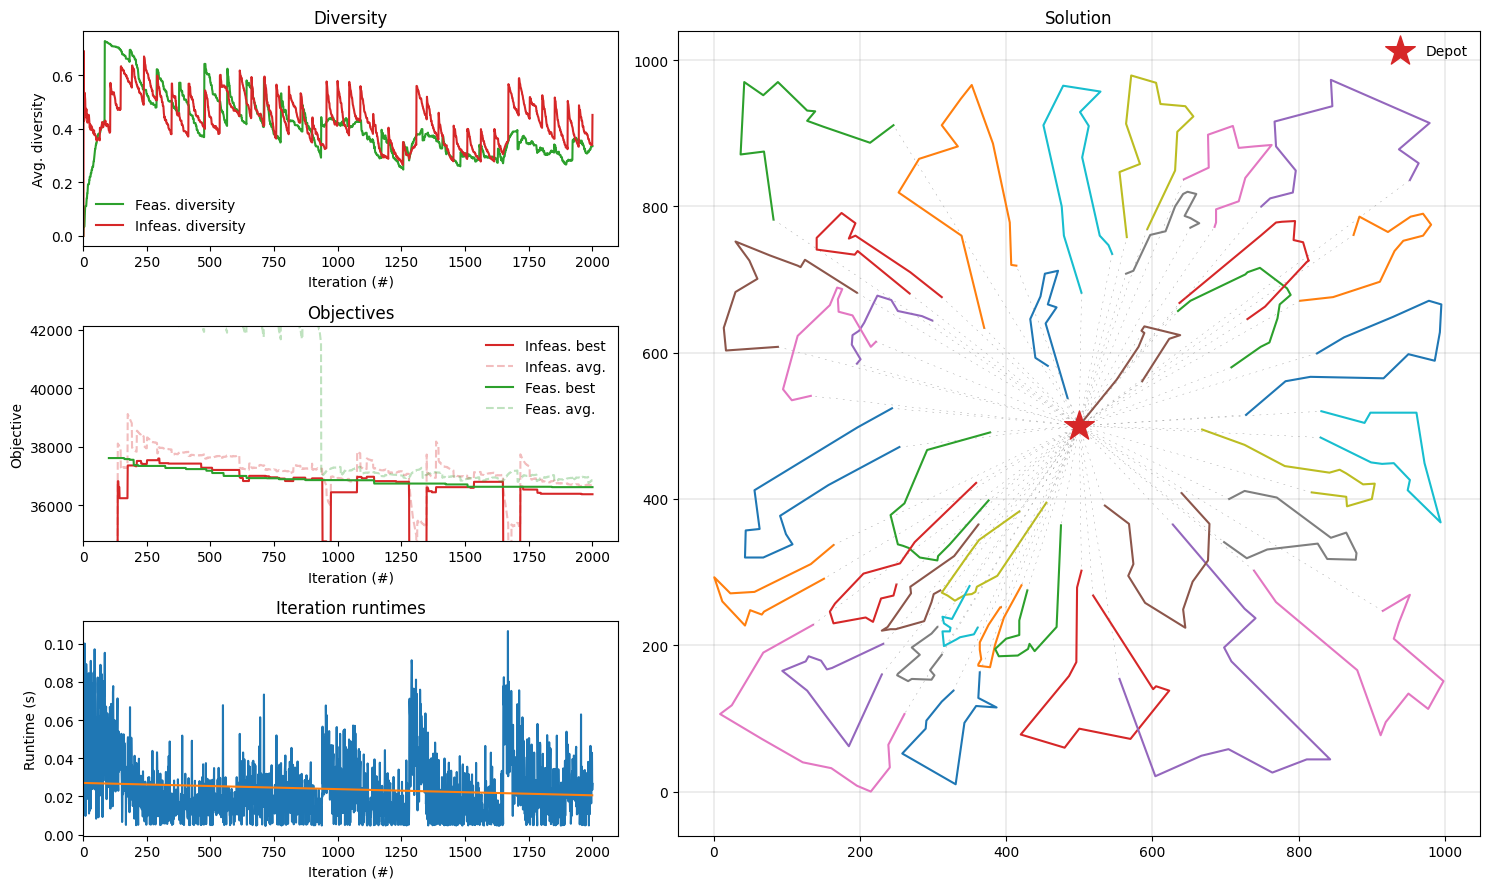

In [6]:
fig = plt.figure(figsize=(15, 9))
plot_result(result, INSTANCE, fig)
fig.tight_layout()

PyVRP internally uses a genetic algorithm consisting of a population of feasible and infeasible solutions.
These solutions are iteratively combined into new offspring solutions, that should result in increasingly better solutions. 
Of course, the solutions should not all be too similar: then there is little to gain from combining different solutions.
The top-left *Diversity* plot tracks the average diversity of solutions in each of the feasible and infeasible solution populations.
The *Objectives* plot gives an overview of the best and average solution quality in the current population.
The bottom-left figure shows iteration runtimes in seconds.
Finally, the *Solution* plot shows the best observed solution.

## The VRP with time windows

### Reading the instance

We start with a basic example that loads an instance and solves it using the standard configuration used by the `Model` interface.
For the basic example we use one of the well-known Solomon instances.

We again use the function `pyvrp.read`.
We pass the following arguments:

- `instance_format="solomon"`: this parses the instance file as a Solomon formatted instance.
- `round_func="trunc1"`: following the [DIMACS VRP challenge](http://dimacs.rutgers.edu/programs/challenge/vrp/) convention, this computes distances and durations truncated to one decimal place.


In [7]:
INSTANCE = read(
    "data/RC208.vrp",
    instance_format="solomon",
    round_func="trunc1",
)
BKS = read_solution("data/RC208.sol")

Let's plot the instance and see what we have.
The function `plot_instance` will plot time windows, demands and coordinates, which should give us a good impression of what the instance looks like.
These plots can also be produced separately by calling the appropriate `plot_*` function: see [the API documentation](https://pyvrp.readthedocs.io/en/latest/api/plotting.html) for details.

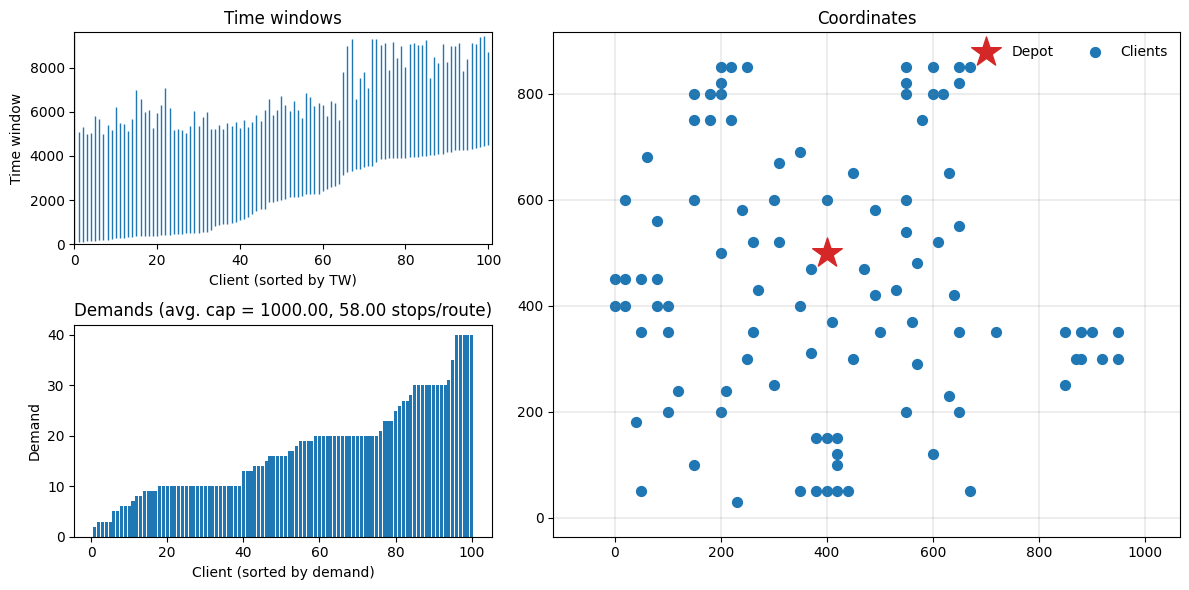

In [8]:
fig = plt.figure(figsize=(12, 6))
plot_instance(INSTANCE, fig)

### Solving the instance

We will again use the `Model` interface to solve the instance.

In [9]:
model = Model.from_data(INSTANCE)
result = model.solve(stop=MaxIterations(1000), seed=42)
print(result)

Solution results
    # routes: 5
   # clients: 100
   objective: 7812.00
# iterations: 1000
    run-time: 2.89 seconds

Routes
------
Route #1: 90 82 99 52 9 10 11 13 15 16 17 47 14 12 53 
Route #2: 65 83 64 49 19 18 48 21 23 25 77 58 75 97 59 87 74 86 57 24 22 20 66 
Route #3: 94 92 95 67 62 50 34 31 29 27 26 28 30 32 33 76 89 63 85 51 84 56 91 80 
Route #4: 61 42 44 39 38 36 35 37 40 43 41 72 71 93 96 54 81 
Route #5: 69 98 88 60 78 73 79 7 6 2 4 46 8 45 5 3 1 70 100 55 68 



In [10]:
cost = result.cost() / 10
gap = 100 * (cost - BKS["cost"]) / BKS["cost"]
print(f"Found a solution with cost: {cost}.")
print(f"This is {gap:.1f}% worse than the optimal solution,", end=" ")
print(f"which is {BKS['cost']}.")

Found a solution with cost: 781.2.
This is 0.7% worse than the optimal solution, which is 776.1.


We've managed to find a (near) optimal solution in a few seconds!

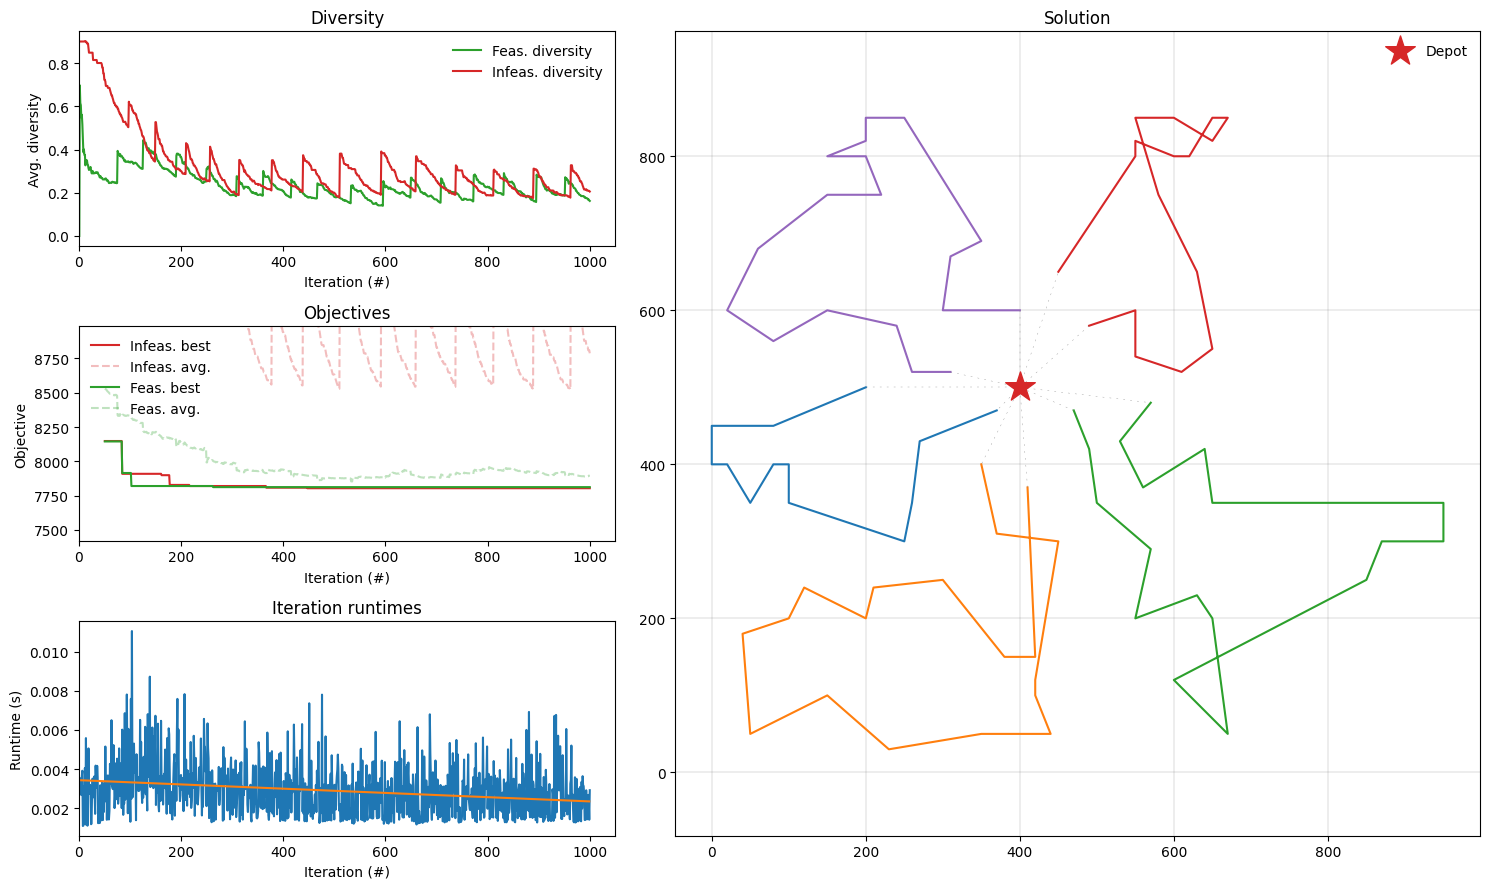

In [11]:
fig = plt.figure(figsize=(15, 9))
plot_result(result, INSTANCE, fig)
fig.tight_layout()

We can also inspect some statistics of the different routes, such as route distance, various durations, the number of stops and total demand.

In [12]:
solution = result.best
routes = solution.get_routes()

data = [
    {
        "num_stops": len(route),
        "distance": route.distance(),
        "service_duration": route.service_duration(),
        "wait_duration": route.wait_duration(),
        "time_warp": route.time_warp(),
        "demand": route.demand(),
    }
    for route in solution.get_routes()
]

header = list(data[0].keys())
rows = [datum.values() for datum in data]
tabulate(rows, header, tablefmt="html")

num_stops,distance,service_duration,wait_duration,time_warp,demand
15,1103,1500,0,0,238
23,1941,2300,0,0,432
24,1983,2400,0,0,381
17,1325,1700,0,0,286
21,1460,2100,0,0,387


We can inspect the routes in more detail using the `plot_route_schedule` function.
This will plot distance on the x-axis, and time on the y-axis, separating actual travel/driving time from waiting and service time.
The clients visited are plotted as grey vertical bars indicating their time windows.
We can see a jump to the start of the time window in the main (earliest) time line when a vehicle arrives early at a customer and has to wait.
In some cases, there is slack in the route indicated by a semi-transparent region on top of the earliest time line.
The grey background indicates the remaining load of the truck during the route, where the (right) y-axis ends at the vehicle capacity.

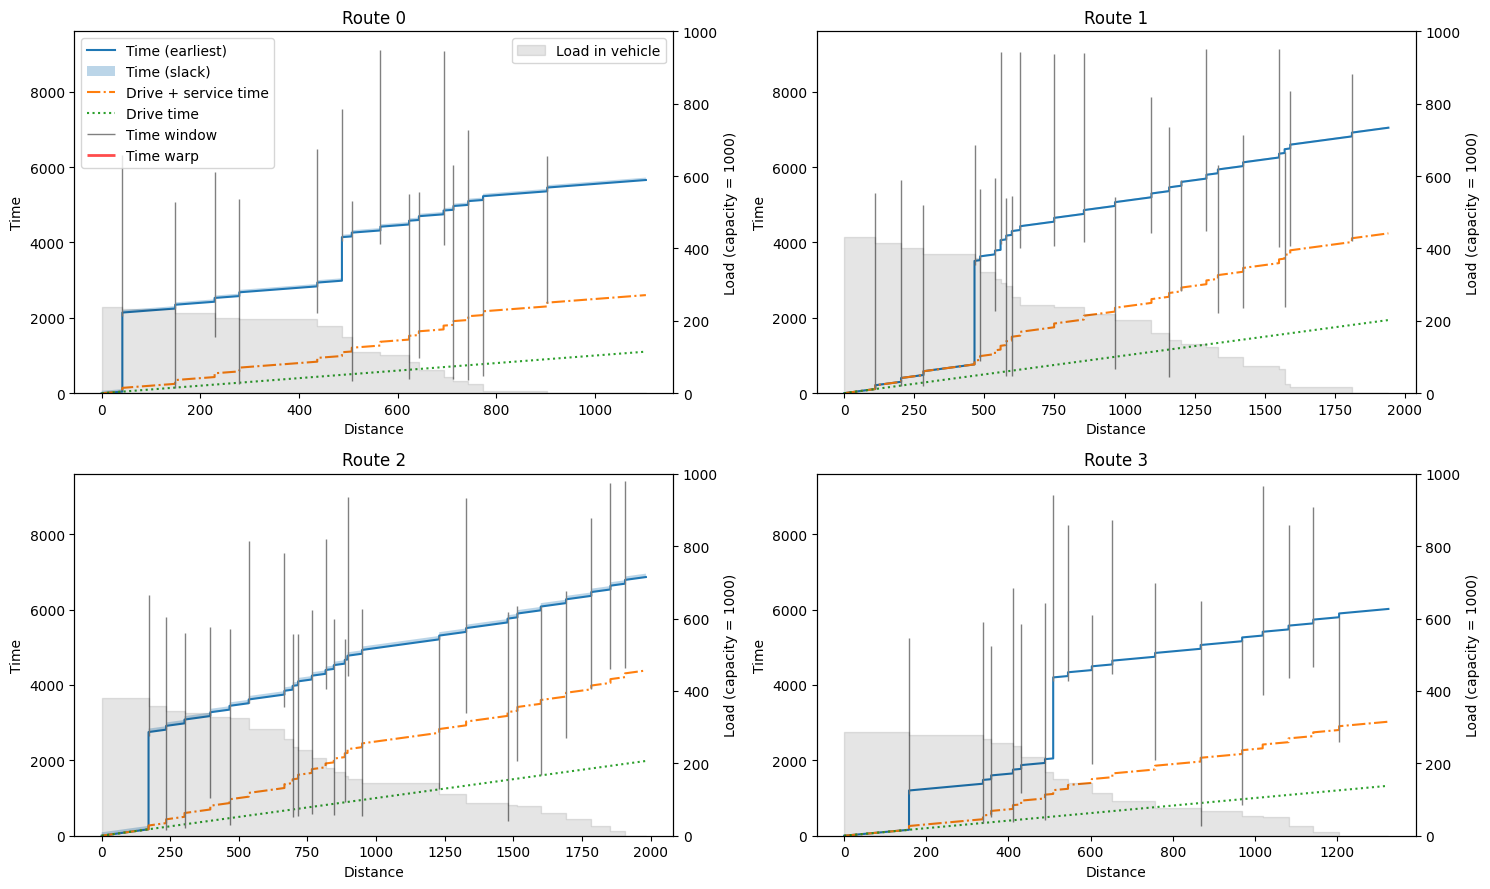

In [13]:
fig, axarr = plt.subplots(2, 2, figsize=(15, 9))
for idx, (ax, route) in enumerate(zip(axarr.reshape(-1), routes)):
    plot_route_schedule(
        INSTANCE,
        route,
        title=f"Route {idx}",
        ax=ax,
        legend=idx == 0,
    )

fig.tight_layout()

## Solving a larger VRPTW instance

To show that PyVRP can also handle much larger instances, we will solve one of the largest Gehring and Homberger VRPTW benchmark instances.
The selected instance - `RC2_10_5` - has 1000 clients.

In [14]:
INSTANCE = read(
    "data/RC2_10_5.vrp",
    instance_format="solomon",
    round_func="trunc1",
)
BKS = read_solution("data/RC2_10_5.sol")

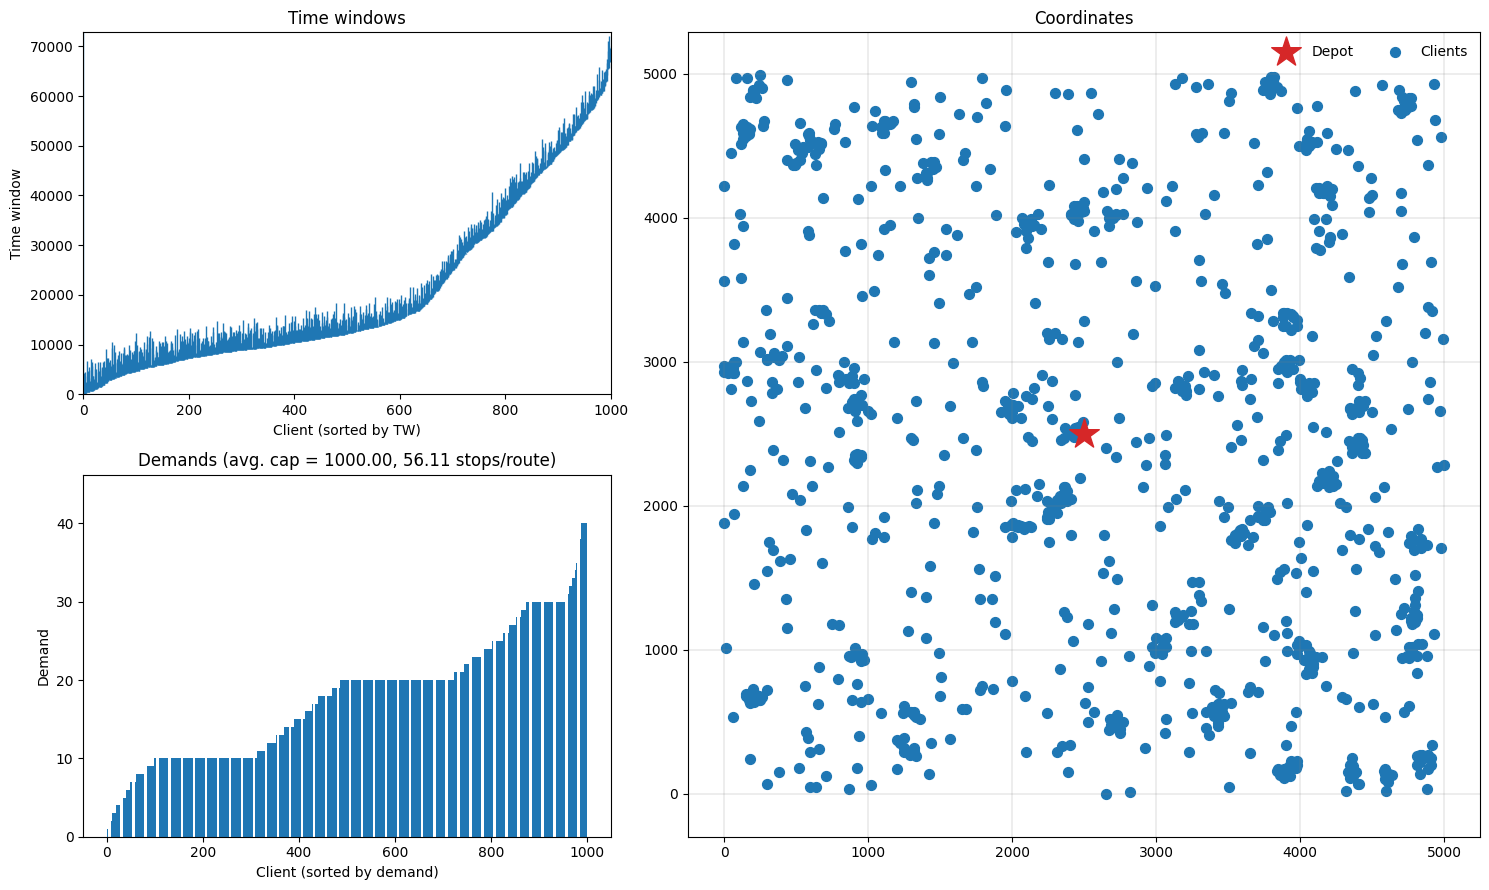

In [15]:
fig = plt.figure(figsize=(15, 9))
plot_instance(INSTANCE, fig)

Here, we will use a runtime-based stopping criterion: we give the solver 30 seconds to compute.

In [16]:
model = Model.from_data(INSTANCE)
result = model.solve(stop=MaxRuntime(30), seed=42)

In [17]:
cost = result.cost() / 10
gap = 100 * (cost - BKS["cost"]) / BKS["cost"]
print(f"Found a solution with cost: {cost}.")
print(f"This is {gap:.1f}% worse than the best-known solution,", end=" ")
print(f"which is {BKS['cost']}.")

Found a solution with cost: 27708.8.
This is 7.4% worse than the best-known solution, which is 25797.5.


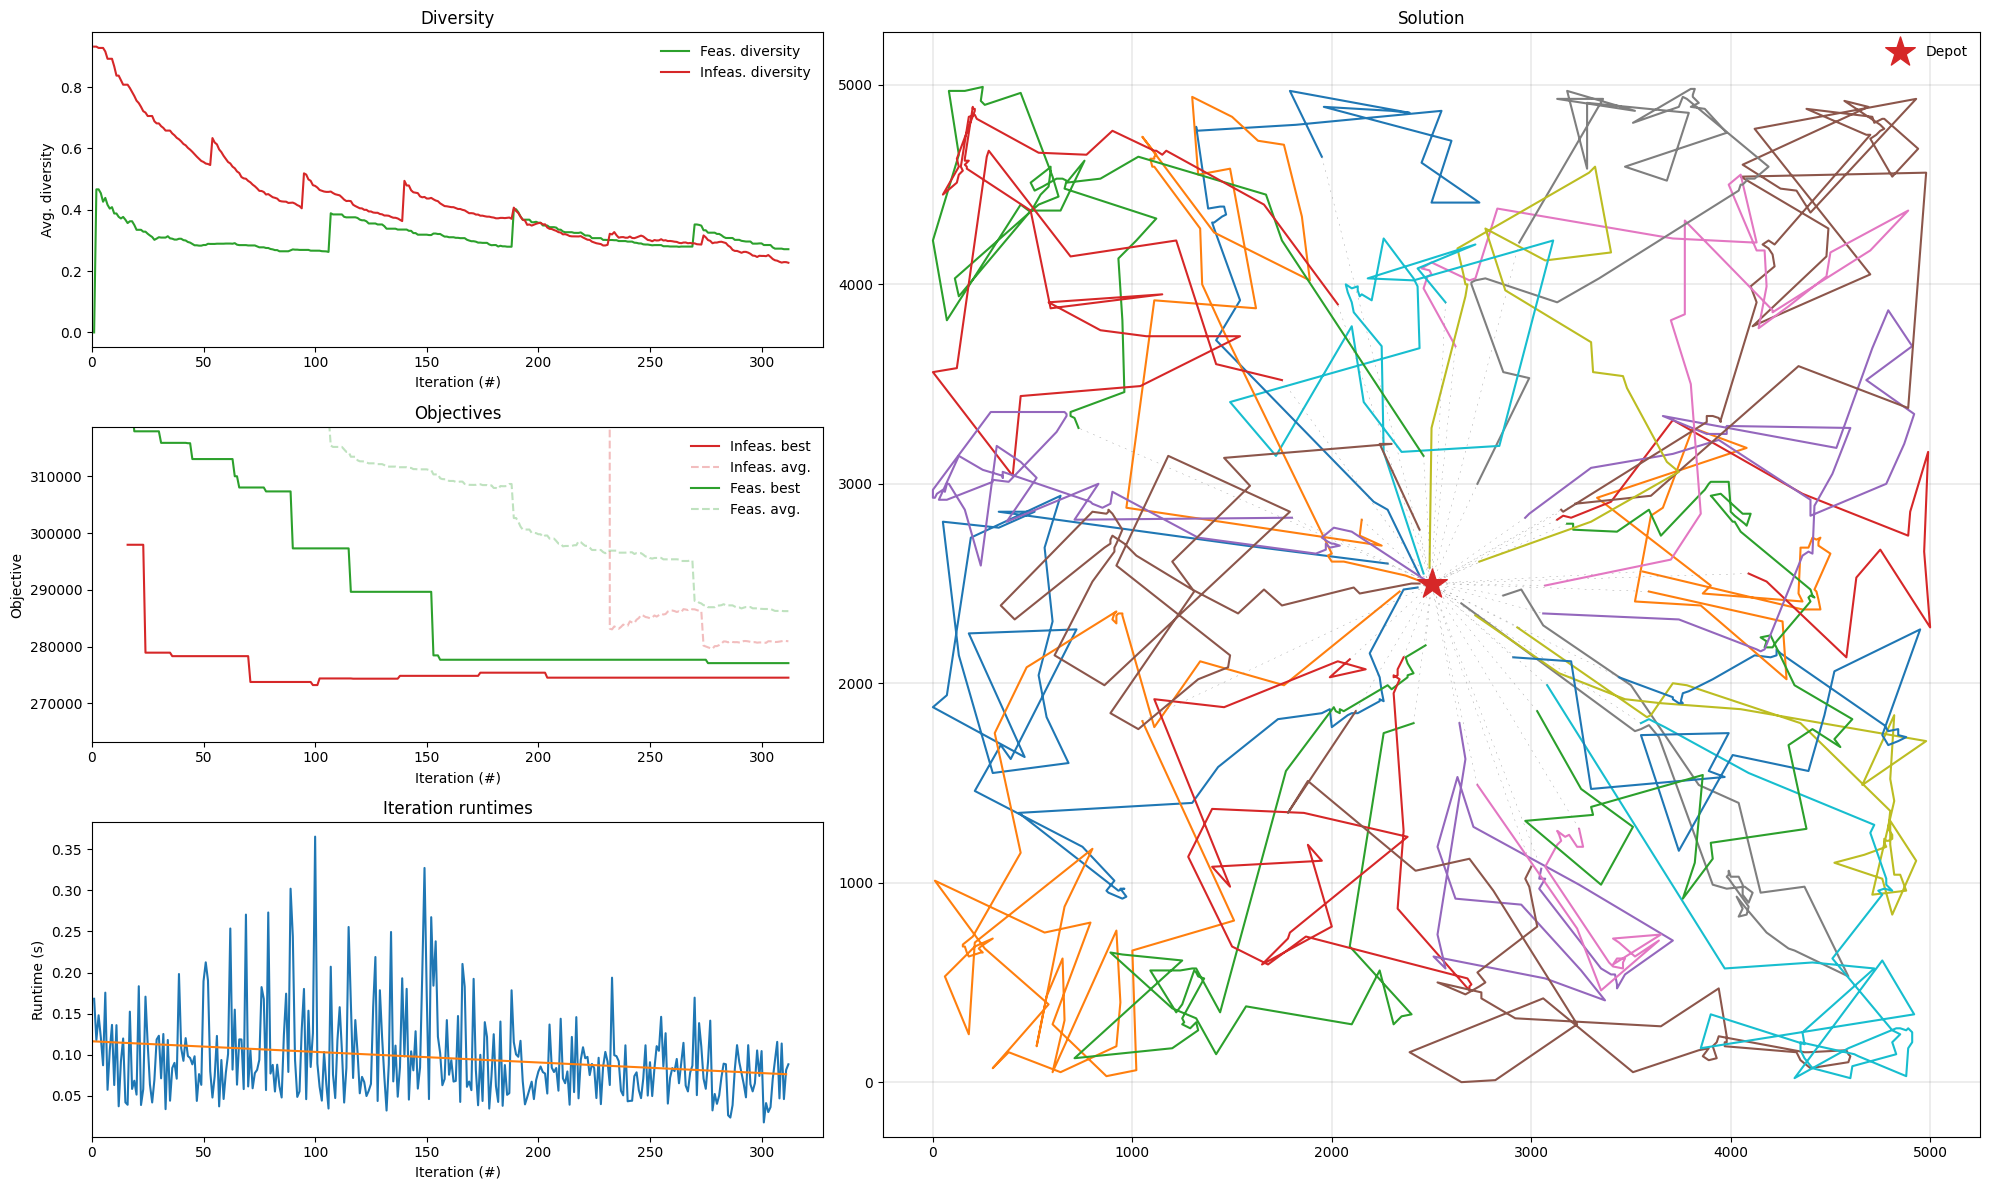

In [18]:
plot_result(result, INSTANCE)
plt.tight_layout()

## Conclusion

In this notebook, we used PyVRP's `Model` interface to solve a CVRP instance with 438 clients to near-optimality, as well as several VRPTW instances, including a large 1000 client instance.
Moreover, we demonstrated how to use the plotting tools to visualise the instance and statistics collected during the search procedure.